In [234]:
# Load libraries
import numpy
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import yfinance as yf
import pandas_datareader.data as pdr
import datetime
import warnings
warnings.filterwarnings('ignore')

In [235]:
#set yfinance to fetch required data
yf.pdr_override

start='2010-01-01'
end=datetime.datetime.now().strftime("%Y-%m-%d")
company='FB'
train_cutoff="2018-12-31"

In [236]:
#function to get data
df = pdr.get_data_yahoo("FB", start, end).reset_index()

#   df.to_csv('FB.csv', index=False)

df['HL_PCT_FB']=(df['High']-df['Low'])/df['Close']*100.0
df['PCT_change_FB']=(df['Close']-df['Open'])/df['Open']*100.0

df.head


<bound method NDFrame.head of            Date    High     Low    Open   Close     Volume  Adj Close  \
0    2012-05-18   45.00   38.00   42.05   38.23  573576400      38.23   
1    2012-05-21   36.66   33.00   36.53   34.03  168192700      34.03   
2    2012-05-22   33.59   30.94   32.61   31.00  101786600      31.00   
3    2012-05-23   32.50   31.36   31.37   32.00   73600000      32.00   
4    2012-05-24   33.21   31.77   32.95   33.03   50237200      33.03   
5    2012-05-25   32.95   31.11   32.90   31.91   37149800      31.91   
6    2012-05-29   31.69   28.65   31.48   28.84   78063400      28.84   
7    2012-05-30   29.55   27.86   28.70   28.19   57267900      28.19   
8    2012-05-31   29.67   26.83   28.55   29.60  111639200      29.60   
9    2012-06-01   29.15   27.39   28.89   27.72   41855500      27.72   
10   2012-06-04   27.65   26.44   27.20   26.90   35230300      26.90   
11   2012-06-05   27.76   25.75   26.70   25.87   42473400      25.87   
12   2012-06-06   27.

In [237]:
# Summarize Data

# Descriptive statistics
# shape
print(df.shape)
# types
print(df.dtypes)
# head
print(df.head(20))
# descriptions, change precision to 2 places
set_option('precision', 1)
print(df.describe())
# correlation
set_option('precision', 2)
print(df.corr(method='pearson'))


(1836, 9)
Date             datetime64[ns]
High                    float64
Low                     float64
Open                    float64
Close                   float64
Volume                    int64
Adj Close               float64
HL_PCT_FB               float64
PCT_change_FB           float64
dtype: object
         Date   High    Low   Open  Close     Volume  Adj Close  HL_PCT_FB  \
0  2012-05-18  45.00  38.00  42.05  38.23  573576400      38.23      18.31   
1  2012-05-21  36.66  33.00  36.53  34.03  168192700      34.03      10.76   
2  2012-05-22  33.59  30.94  32.61  31.00  101786600      31.00       8.55   
3  2012-05-23  32.50  31.36  31.37  32.00   73600000      32.00       3.56   
4  2012-05-24  33.21  31.77  32.95  33.03   50237200      33.03       4.36   
5  2012-05-25  32.95  31.11  32.90  31.91   37149800      31.91       5.77   
6  2012-05-29  31.69  28.65  31.48  28.84   78063400      28.84      10.54   
7  2012-05-30  29.55  27.86  28.70  28.19   57267900      28.19 

In [238]:
#preprocess data
scaler=StandardScaler()

X_train=df[df['Date']<=train_cutoff].drop(['Close','Adj Close','Date'],axis=1)
X_test=df[df['Date']>train_cutoff].drop(['Close','Adj Close','Date'],axis=1)

X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

Y_train=df[df['Date']<=train_cutoff]['Close']
Y_test=df[df['Date']>train_cutoff]['Close']


# Evaluate Algorithms
# Test options and evaluation metric
num_folds = 20
seed = 7
scoring = 'neg_mean_squared_error'

In [239]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [240]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    

LR: -0.412985 (0.490226)
LASSO: -2.142513 (1.674840)
EN: -82.169061 (83.265551)
KNN: -35.395878 (29.490449)
CART: -5.297732 (13.752409)
SVR: -163.514851 (264.543669)


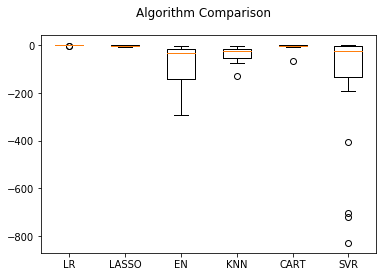

In [241]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [242]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
results = []
names = []
for name, model in pipelines:
	kfold = KFold(n_splits=num_folds, random_state=seed)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)


ScaledLR: -0.412985 (0.490226)
ScaledLASSO: -2.073330 (1.570941)
ScaledEN: -75.788830 (72.165108)
ScaledKNN: -35.277775 (28.878006)
ScaledCART: -5.172836 (13.734962)
ScaledSVR: -170.540481 (279.196226)


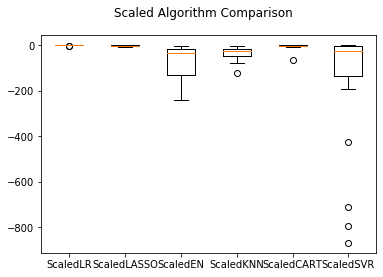

In [243]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

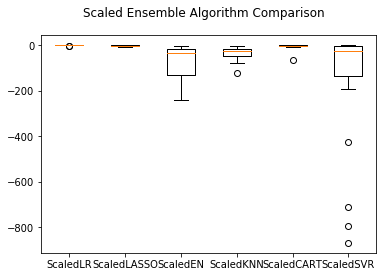

In [244]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()